In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset

In [3]:
df = pd.read_csv("./data/processed/Mastercard_stock_history_processed.csv")
df.head()
# df = df[["Open", "Volume",  "lag_1","lag_2","MA","M_STD", "month", "day","quarter","Close"]]
df = df[["Volume", "Open", "day", "MA", "M_STD", "day", "quarter", "Close"]]

In [4]:
train_df = df[:-100]
test_df = df[-100:]

In [7]:
def create_dataset(dataset, n):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        n: Size of window for prediction
    """
    X, y = [], [] 
    for i in range(len(dataset)-n):
        feature = dataset[i:i+n, :] # (n, feature_size)
        target = dataset[i+n, -1] # scalar (of next value)
        X.append(feature)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# train_df_torch = torch.from_numpy(train_df.to_numpy()).type(torch.float32)
# test_df_torch = torch.from_numpy(test_df.to_numpy()).type(torch.float32)
X_train, y_train = create_dataset(train_df.to_numpy(), 4)
X_test, y_test = create_dataset(test_df.to_numpy(), 4)
X_train.shape, y_train.shape, X_test.shape, y_test.shape
# X_train, y_train = train_df_torch[:, :-1], train_df_torch[:, -1].reshape(-1, 1)
# X_test, y_test= test_df_torch[:, :-1], test_df_torch[:, -1].reshape(-1, 1)


(torch.Size([5482, 4, 8]),
 torch.Size([5482, 1]),
 torch.Size([96, 4, 8]),
 torch.Size([96, 1]))

In [8]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        
    
    def forward(self, x):
        # assume x is (N,L,input_size)
        out, _ = self.lstm(x)
        # print("out shape:", out.shape)
        return self.fc(out[:, -1, :])

In [9]:
class TimeSeriesANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layer
        self.input = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.Sigmoid(),
        )
        self.mlp_block1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 512),
            nn.ELU(alpha=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope = 0.15),
        )

      
        self.output_lyr = nn.Linear(512, output_size)
        
    
    def forward(self, x):
        a0 = self.input(x)
        a1 = self.mlp_block1(a0)
        a2 = self.output_lyr(a1)
        return a2


In [10]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [22]:
model = TimeSeriesLSTM(
    input_size=8,
    hidden_size=100,
    num_layers=10,
    dropout_rate=0.2
)

model.apply(initialize_weights)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.0001)
# loader = load_data("data/processed/mastercard_stock_history_processed.csv", batch_size=8)
loader = DataLoader(TensorDataset(X_train, y_train), shuffle = False, batch_size = 70)
train_rmse_lst = []
test_rmse_lst = []
 
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # scheduler.step()
    # Validation
    if epoch % 5 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # train_rmse = loss_fn(y_pred, y_train)
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))

        train_rmse_lst.append(train_rmse)
        test_rmse_lst.append(test_rmse)
        # test_rmse = loss_fn(y_pred, y_test)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 131.1482, test RMSE 343.8870
Epoch 5: train RMSE 123.5060, test RMSE 331.2692
Epoch 10: train RMSE 117.3808, test RMSE 320.3813
Epoch 15: train RMSE 111.1357, test RMSE 310.1170
Epoch 20: train RMSE 105.8064, test RMSE 299.9923
Epoch 25: train RMSE 100.5980, test RMSE 290.4599
Epoch 30: train RMSE 96.1604, test RMSE 281.3774
Epoch 35: train RMSE 91.9842, test RMSE 272.7932
Epoch 40: train RMSE 87.8716, test RMSE 264.3702
Epoch 45: train RMSE 83.8699, test RMSE 256.0686
Epoch 50: train RMSE 79.9687, test RMSE 247.9093
Epoch 55: train RMSE 76.3029, test RMSE 239.8583
Epoch 60: train RMSE 72.8762, test RMSE 231.9288
Epoch 65: train RMSE 70.4495, test RMSE 224.1829
Epoch 70: train RMSE 67.4951, test RMSE 216.5658
Epoch 75: train RMSE 63.2448, test RMSE 209.1642
Epoch 80: train RMSE 60.1743, test RMSE 201.8994
Epoch 85: train RMSE 60.9147, test RMSE 194.7661
Epoch 90: train RMSE 56.6688, test RMSE 187.7492
Epoch 95: train RMSE 54.1071, test RMSE 180.9327
Epoch 100: train

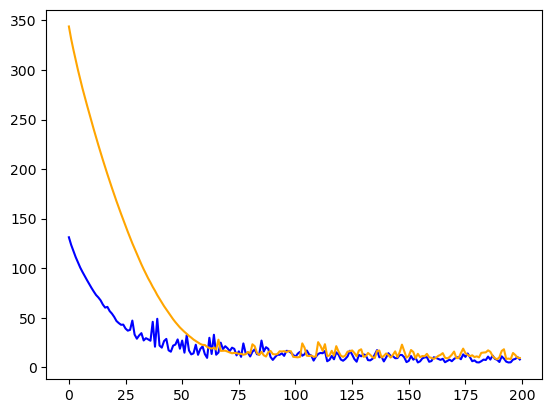

In [23]:
plt.plot(train_rmse_lst, color = "blue")
plt.plot(test_rmse_lst, color = "orange")
plt.show()

# To experiment with some deep learning models on the time series data given